Fashion MNIST Classification using PyTorch

In [75]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time

%matplotlib inline

1. Prepare the DataLoader

In [76]:
# Set random seed for reproducibility
def set_seeds():
    # set random seed value
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    # Fix seed to make training deterministic.
    if torch.cuda.is_available():
       torch.cuda.manual_seed(SEED_VALUE)
       torch.cuda.manual_seed_all(SEED_VALUE)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seeds()

In [77]:
#Convert to Tensors and Normalize
transform = transforms.Compose([
    # Convert the images (28x28) to PyTorch tensors (of shape [1,28,28])
    transforms.ToTensor(),
    # Normalizes each pixel by subtracting 0.5 and dividing by 0.5
    # This scales the pixel values to the range [-1, 1]
    transforms.Normalize((0.5,), (0.5,))  # mean, std
])

# Download and load the training data
train_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = True, transform = transform)
val_set = datasets.FashionMNIST(root = "F_MNIST_data", download = True, train = False, transform = transform) #Test set

print("Total Train Images: ", len(train_set))
print("Total Val Images: ", len(val_set))

Total Train Images:  60000
Total Val Images:  10000


In [78]:
# Shuffle the training set
train_loader = torch.utils.data.DataLoader(train_set, shuffle = True, batch_size = 64)
val_loader = torch.utils.data.DataLoader(val_set, shuffle = False, batch_size = 64)

In [79]:
#class to idx mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

2. Dataset Visualization

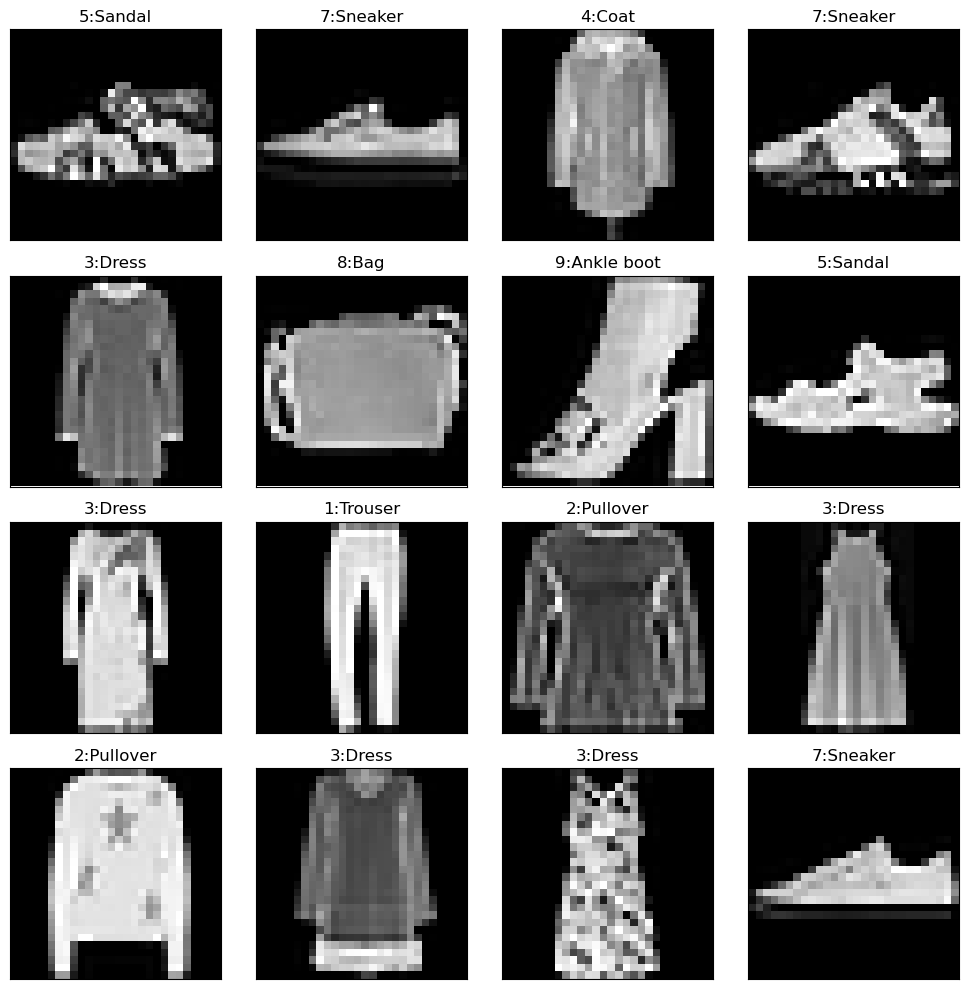

In [80]:
def visualize_images(trainloader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over the first batch
    images, labels = next(iter(trainloader))

    #To calculate the number of rows and columns for subplots
    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
      image, label = images[idx], labels[idx]

      ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(image), cmap="gray")
      ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()

visualize_images(train_loader, num_images=16)

3. Model Architecture

3.1 Deep Neural Network Architecture

The network architecture shown below has multiple layers. An input layer, five hidden layers, and an output layer. There are several things to note about this architecture.

    1. Input Data: The image input data is pre-processed (flattened) from a 2-Dimensional array [28x28] to 1-Dimensional vector of length [784x1] where the elements in this input vector are the normalized pixel intensities.

    2. Hidden Layers: We have five hidden layers that contain some number of neurons (that we need to specify). Each of the neurons in these layers has a non-linear activation function (e.g., ReLU, Sigmoid, etc.).

    3. Output Layer: We now have ten neurons in the output layer to represent the ten different classes (cloth items: 0 to 9), instead of a single neuron as in the regression example.

    4. Dense Layers: All the layers in the network are fully connected, meaning that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer. The weights associated with each layer are represented in bold to indicate that these are matrices that contain each of the weights for all the connections between adjacent layers in the network.

    5. Softmax Function: The values from each of the neurons in the output layer are pased through a log_softmax() function to produce a probability score for each of the ten cloth items in the dataset.

    6. Network Output: The network output (y′), is a vector of length ten, that contains the probabilities of each output neuron. Predicting the class label simply requires passing (y′) through the argmax function to determine the index of the predicted label.

    7. Loss Function: The loss function used is Negative Log Likelihood Loss. It is computed from the ground truth labels (y) and the output log probabilities of the network (y′). Note that y and y′ are both matrices whose shape is (Bacth Size, Num Classes).

    Check out the png in this folder

4. Multi Layer Perceptron Model Implementation

In [81]:
# Defines a Multi-Layer Perceptron (MLP) model for FashionMNIST classification.
# The model consists of several fully connected layers with batch normalization, ReLU activation, and dropout
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 784 input features (28x28 flattened image) to 512 neurons in first hidden layer
        self.fc0 = nn.Linear(784, 512)
        self.bn0 = nn.BatchNorm1d(512)
        # 512 neurons to 256 neurons in second hidden layer
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        # 256 neurons to 128 neurons in third hidden layer
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        # 128 neurons to 64 neurons in fourth hidden layer
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        # 64 neurons to num_classes (10) in output layer
        # This layer does not have a batch norm layer because it is the output layer
        self.fc4 = nn.Linear(64,num_classes)
        # Dropout layer to prevent overfitting
        # Randonly sets 30% of the neurons to zero during training
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.shape[0], -1) #(B,784)  --> 28x28 = 784
        # First fully connected layer with ReLU, batch norm, and dropout
        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Output layer with softmax activation
        x = F.relu(self.bn3(self.fc3(x)))
        # log_softmax converts the output to log probabilities 
        x = F.log_softmax(self.fc4(x), dim = 1)

        return x

# Instantiate the model.
mlp_model = MLP(num_classes = 10)

In [82]:
#A dummy input size of (B,C,H,W) = (1,1,28,28) is passed.
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))
# Display the model summary.

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Dropout (dropout)                      [1, 128]                  --
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable

4.1 Training Configuration

In [83]:
# Loss function
criterion = F.nll_loss #Negative Log Likelihood Loss
# Optimizer 
# The Adam optimizer is used with a learning rate of 0.01
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2) 
num_epochs = 40
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

4.2 Model Training

In [84]:
def train(model, trainloader, criterion, optimizer, DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # iterate over the training data
    # For each batch of images and labels in the trainloader
    for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        # Forward pass: compute the model outputs
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Computes gradients via backpropagation
        loss.backward()
        # Updates model weights using gradients
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [85]:
# Evaluates the model on the validation (test) set.
# Returns average loss and accuracy.
# Does NOT modify the model or its weights
def validation(model, val_loader, criterion, DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [86]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/40 - Train Loss: 0.5619, Train Accuracy: 79.98% - Val Loss: 0.4325, Val Accuracy: 84.65%
Epoch 02/40 - Train Loss: 0.4370, Train Accuracy: 84.34% - Val Loss: 0.3821, Val Accuracy: 85.84%
Epoch 03/40 - Train Loss: 0.3966, Train Accuracy: 85.85% - Val Loss: 0.3773, Val Accuracy: 85.95%
Epoch 04/40 - Train Loss: 0.3736, Train Accuracy: 86.53% - Val Loss: 0.3481, Val Accuracy: 87.55%
Epoch 05/40 - Train Loss: 0.3536, Train Accuracy: 87.27% - Val Loss: 0.3487, Val Accuracy: 87.50%
Epoch 06/40 - Train Loss: 0.3391, Train Accuracy: 87.73% - Val Loss: 0.3313, Val Accuracy: 88.11%
Epoch 07/40 - Train Loss: 0.3267, Train Accuracy: 88.19% - Val Loss: 0.3509, Val Accuracy: 87.07%
Epoch 08/40 - Train Loss: 0.3132, Train Accuracy: 88.67% - Val Loss: 0.3251, Val Accuracy: 88.40%
Epoch 09/40 - Train Loss: 0.3032, Train Accuracy: 89.00% - Val Loss: 0.3158, Val Accuracy: 88.45%
Epoch 10/40 - Train Loss: 0.2958, Train Accuracy: 89.19% - Val Loss: 0.3195, Val Accuracy: 88.66%
Epoch 11/40 - Train 

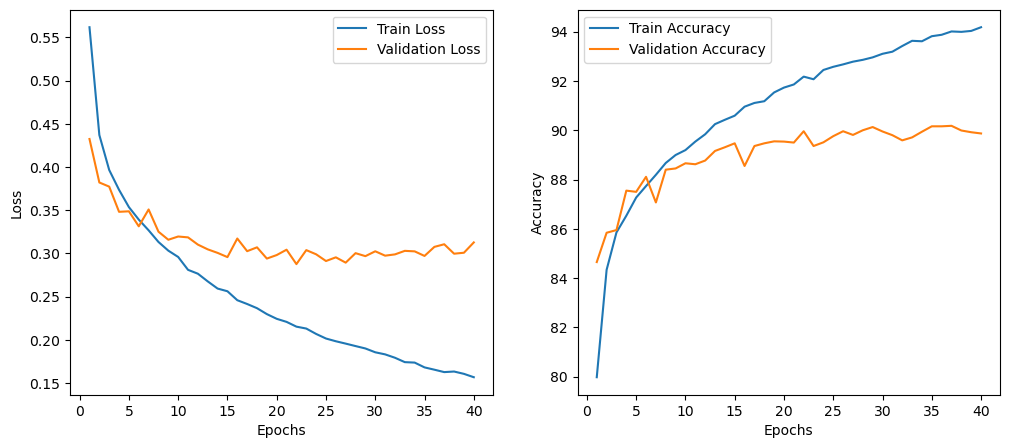

In [87]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

5. Inference Results

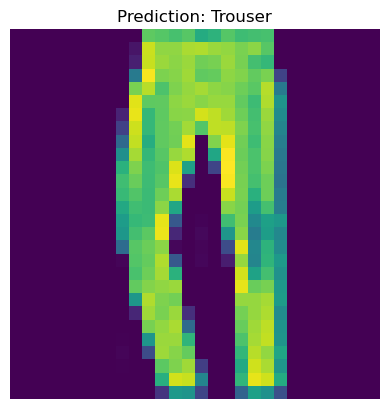

In [128]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Prediction: " + str(class_mapping[int(gt_labels[rand_idx])]), fontsize = 12)
plt.axis("off")
plt.show()

In [109]:
bold = f"\033[1m"
reset = f"\033[0m"
mlp_model.eval()

with torch.no_grad():
     batch_outputs = mlp_model(images.to(DEVICE))

prob_score_batch = batch_outputs.softmax(dim=1).cpu()

prob_score_test_image = prob_score_batch[rand_idx]
pred_cls_id = prob_score_test_image.argmax()

print("Predictions for each class on the test image:\n")

for idx, cls_prob in enumerate(prob_score_test_image):
    if idx == pred_cls_id:
       print(f"{bold}Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}{reset}")
    else:
       print(f"Class: {idx} - {class_mapping[idx]}, Probability: {cls_prob:.3f}")

Predictions for each class on the test image:

Class: 0 - T-shirt/top, Probability: 0.001
Class: 1 - Trouser, Probability: 0.000
Class: 2 - Pullover, Probability: 0.000
Class: 3 - Dress, Probability: 0.000
Class: 4 - Coat, Probability: 0.000
Class: 5 - Sandal, Probability: 0.000
Class: 6 - Shirt, Probability: 0.002
Class: 7 - Sneaker, Probability: 0.000
Class: 8 - Bag, Probability: 0.997
Class: 9 - Ankle boot, Probability: 0.000


5.1 Confusion Matrix

Used to summarize the results of a classification problem

In [131]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [132]:
def prediction_batch(model, batch_inputs):
    model.eval()

    batch_outputs = model(batch_inputs)

    with torch.no_grad():
        batch_probs = batch_outputs.softmax(dim=1) #along num of classes dimension

    batch_cls_ids = batch_probs.argmax(dim=1)

    return batch_cls_ids.cpu()


In [133]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = prediction_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

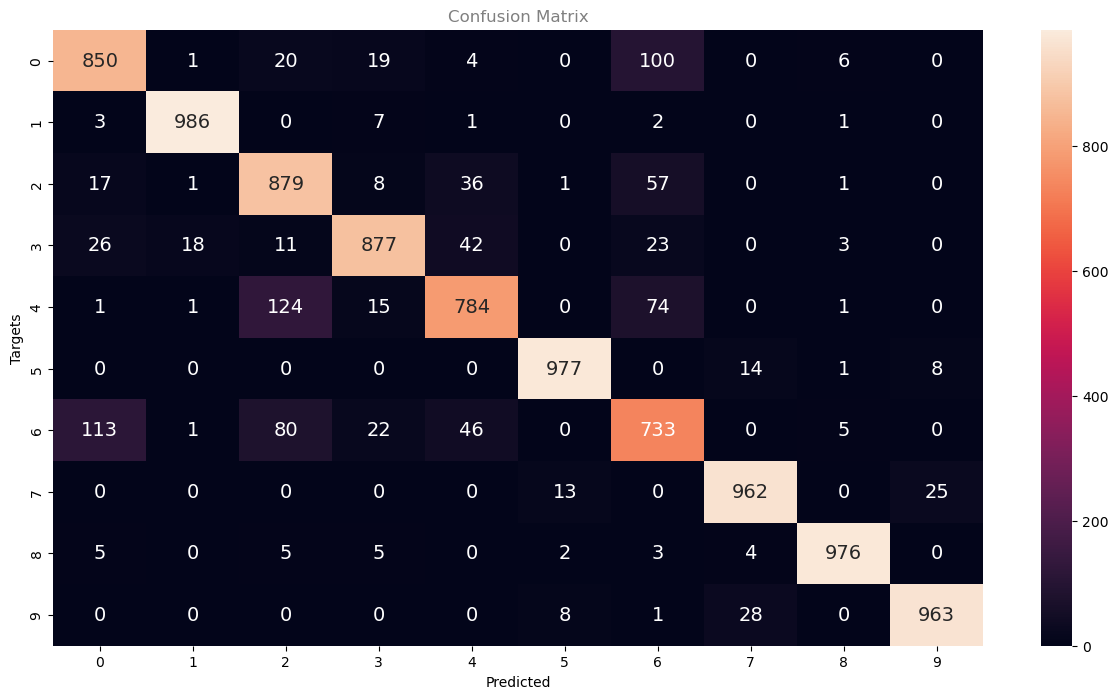

In [134]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])

# Plot the confusion matrix as a heatmap.
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()